In [1]:
import os
os.environ["OMP_NUM_THREADS"] = "4"
import numpy as np
import matplotlib.pyplot as plt
import h5py
import time
from mpl_toolkits import mplot3d
import matplotlib as mpl
from matplotlib.gridspec import GridSpec
import scipy.stats as stats
mpl.rc('text', usetex = True)
mpl.rc('font', family = 'serif')

import tensorflow as tf #code is implemented in TF 2.x
tf.config.set_visible_devices([], 'GPU')
tf.config.threading.set_inter_op_parallelism_threads(4) 
tf.config.threading.set_intra_op_parallelism_threads(2)
tf.keras.backend.set_floatx('float64')
from tensorflow.python.ops import math_ops

# model-free ESN
%run ESN_bias.ipynb
# model to compute reservoir state derivative
%run ESN_bias_drdt.ipynb

## Data

We load the data and treat it for the different cases:

(i)   given [x,z] reconstruct [y]

(ii)  given [x,y] reconstruct [z]

(iii) given [x]   reconstruct [y,z]

In [2]:
## Load data obtained using scipy.odeint
hf       = h5py.File('./data/Lorenz_odeint.h5','r')
u_exact  = np.array(hf.get('q'))
t        = np.array(hf.get('t'))
hf.close()

t_lyap    = 0.906**(-1)    # Lyapunov time
dt        = t[1]-t[0]      # timestep 

# norm is the maximum variation, used for the Normalized Root Mean Square Error
m    = u_exact.min(axis=0)
M    = u_exact.max(axis=0)
norm = M-m
print(norm)

## Parameters for the split of the training/validation ----------------------------
batches = 1 # number of batches for training

begin = 50 # begin of training (wash out at the start to remove the transient of the reservoir)
end = 10050 # has to be equal or smaller than end - this can be used for a "validation" of the ESN
horizon = 10000 # size of the test set

cut1 = 1000 # to get rid of the initial transient in the simulation
cut2 = cut1+end+horizon+1  
u_exact = u_exact[np.arange(cut1,cut2),:] # we keep only the necessary data

### Treatment of inputs -----------------------------------------------------------
Nx = u_exact.shape[1]
num_inputs1 = Nx - 1 #for (i)-(ii)
num_inputs3 = Nx - 2 #for (iii)

wave       = u_exact[:end+1,:].astype("float64")

idx1       = [0,2] # for (i)
idx_1      = [0,2,1]
idx2       = [0,1]  # for (ii) 
idx_2      = [0,1,2]
idx3       = [0]   # for (iii)
idx_3      = [0,1,2]
rnn_inputs1     = wave[:-1,idx1].reshape(1,end, num_inputs1)
rnn_inputs2     = wave[:-1,idx2].reshape(1,end, num_inputs1)
rnn_inputs3     = wave[:-1,idx3].reshape(1,end, num_inputs3)

### Treatment of output ------------------------------------------------------------
rnn_target1 = wave[1:,idx1]
rnn_target2 = wave[1:,idx2]
rnn_target3 = wave[1:,idx3]

### Time derivative     ------------------------------------------------------------
def Lorenz_RHS(yy): 
    """Computes RHS of Lorenz equations"""
    # Lorenz parameters
    sigma, rho, beta = [10.0, 28.0, 8./3.]
    # Lorenz equations
    x,y,z = yy.T
    x1    = sigma*(y-x)
    y1    = rho*x - y - np.multiply(x,z)
    z1    = np.multiply(x,y) - beta*z
    return np.stack([x1,y1,z1],axis=1)

#same treatment of the inputs
u_der = Lorenz_RHS(u_exact) #RHS of the equations, namely the system true time derivative
wave_der   = u_der[:end+1,:].astype("float64")
rnn_inputs_der1 = wave_der[:-1,idx1].reshape(1,end, num_inputs1)
rnn_inputs_der2 = wave_der[:-1,idx2].reshape(1,end, num_inputs1)
rnn_inputs_der3 = wave_der[:-1,idx3].reshape(1,end, num_inputs3)

[37.62101167 51.37309572 43.50164215]


## ESN Generation

We create ESNs of different sizes, and with different input matrices, as the case with only one input (iii) has different input matrix with respect to the others (i)-(ii)

In [3]:
### ESN hyperparameters for all the different sizes of the networks
num_units1   = 100 #neurons
num_units2   = 200
num_units5   = 500
num_units7   = 750
num_units10  = 1000

decay        = 1.0 # for leaky-ESN
rho_spectral = 0.9 # spectral radius of Wecho
sigma_in     = 0.1 # scaling of input

connectivity = 20
sparseness1  = 1. - connectivity/ (num_units1 - 1.) # sparseness 
sparseness2  = 1. - connectivity/ (num_units2 - 1.) 
sparseness5  = 1. - connectivity/ (num_units5 - 1.) 
sparseness7  = 1. - connectivity/ (num_units7 - 1.) 
sparseness10 = 1. - connectivity/ (num_units10 - 1.) 

lmb          = 1e-6 # Tikhonov factor
activation   = lambda x: tf.keras.activations.tanh(x) #the activation function of the ESN
b_in         = 10   #input bias

#random numbers
random_seed = 1
rng        = np.random.RandomState(random_seed)
# Initialize the ESN cells of different size. 
# For each size, we add cellx3 to create the cells for case (iii)
# the cells in (iii) differ from (i)-(ii) because the size of input is different
cell1 = EchoStateRNNCell(num_units=num_units1, 
                        num_inputs=num_inputs1,
                        activation=activation, 
                        decay=decay, # decay (leakage) rate
                        rho=rho_spectral, # spectral radius of echo matrix
                        sigma_in=sigma_in, # scaling of input matrix
                        b_in = b_in,
                        sparseness = sparseness1, # sparsity of the echo matrix
                        rng=rng)

rng        = np.random.RandomState(random_seed)
cell13 = EchoStateRNNCell(num_units=num_units1, 
                        num_inputs=num_inputs3,
                        activation=activation, 
                        decay=decay, # decay (leakage) rate
                        rho=rho_spectral, # spectral radius of echo matrix
                        sigma_in=sigma_in, # scaling of input matrix
                        b_in = b_in,
                        sparseness = sparseness1, # sparsity of the echo matrix
                        rng=rng)

rng        = np.random.RandomState(random_seed)
cell2 = EchoStateRNNCell(num_units=num_units2, 
                        num_inputs=num_inputs1,
                        activation=activation, 
                        decay=decay, # decay (leakage) rate
                        rho=rho_spectral, # spectral radius of echo matrix
                        sigma_in=sigma_in, # scaling of input matrix
                        b_in = b_in,
                        sparseness = sparseness2, # sparsity of the echo matrix
                        rng=rng)

rng        = np.random.RandomState(random_seed)
cell23 = EchoStateRNNCell(num_units=num_units2, 
                        num_inputs=num_inputs3,
                        activation=activation, 
                        decay=decay, # decay (leakage) rate
                        rho=rho_spectral, # spectral radius of echo matrix
                        sigma_in=sigma_in, # scaling of input matrix
                        b_in = b_in,
                        sparseness = sparseness2, # sparsity of the echo matrix
                        rng=rng)

rng        = np.random.RandomState(random_seed)
cell5 = EchoStateRNNCell(num_units=num_units5, 
                        num_inputs=num_inputs1,
                        activation=activation, 
                        decay=decay, # decay (leakage) rate
                        rho=rho_spectral, # spectral radius of echo matrix
                        sigma_in=sigma_in, # scaling of input matrix
                        b_in = b_in,
                        sparseness = sparseness5, # sparsity of the echo matrix
                        rng=rng)

rng        = np.random.RandomState(random_seed)
cell53 = EchoStateRNNCell(num_units=num_units5, 
                        num_inputs=num_inputs3,
                        activation=activation, 
                        decay=decay, # decay (leakage) rate
                        rho=rho_spectral, # spectral radius of echo matrix
                        sigma_in=sigma_in, # scaling of input matrix
                        b_in = b_in,
                        sparseness = sparseness5, # sparsity of the echo matrix
                        rng=rng)

rng        = np.random.RandomState(random_seed)
cell7 = EchoStateRNNCell(num_units=num_units7, 
                        num_inputs=num_inputs1,
                        activation=activation, 
                        decay=decay, # decay (leakage) rate
                        rho=rho_spectral, # spectral radius of echo matrix
                        sigma_in=sigma_in, # scaling of input matrix
                        b_in = b_in,
                        sparseness = sparseness7, # sparsity of the echo matrix
                        rng=rng)

rng        = np.random.RandomState(random_seed)
cell73 = EchoStateRNNCell(num_units=num_units7, 
                        num_inputs=num_inputs3,
                        activation=activation, 
                        decay=decay, # decay (leakage) rate
                        rho=rho_spectral, # spectral radius of echo matrix
                        sigma_in=sigma_in, # scaling of input matrix
                        b_in = b_in,
                        sparseness = sparseness7, # sparsity of the echo matrix
                        rng=rng)

rng        = np.random.RandomState(random_seed)
cell10 = EchoStateRNNCell(num_units=num_units10, 
                        num_inputs=num_inputs1,
                        activation=activation, 
                        decay=decay, # decay (leakage) rate
                        rho=rho_spectral, # spectral radius of echo matrix
                        sigma_in=sigma_in, # scaling of input matrix
                        b_in = b_in,
                        sparseness = sparseness10, # sparsity of the echo matrix
                        rng=rng)

rng        = np.random.RandomState(random_seed)
cell103 = EchoStateRNNCell(num_units=num_units10, 
                        num_inputs=num_inputs3,
                        activation=activation, 
                        decay=decay, # decay (leakage) rate
                        rho=rho_spectral, # spectral radius of echo matrix
                        sigma_in=sigma_in, # scaling of input matrix
                        b_in = b_in,
                        sparseness = sparseness10, # sparsity of the echo matrix
                        rng=rng)

#creating the different ESNs fom the cells
ESN1 = tf.keras.layers.RNN(cell=cell1,dtype=tf.float64,
                                              return_sequences=True, return_state=True)
ESN13 = tf.keras.layers.RNN(cell=cell13,dtype=tf.float64,
                                              return_sequences=True, return_state=True)
ESN2 = tf.keras.layers.RNN(cell=cell2,dtype=tf.float64,
                                              return_sequences=True, return_state=True)
ESN23 = tf.keras.layers.RNN(cell=cell23,dtype=tf.float64,
                                              return_sequences=True, return_state=True)
ESN5 = tf.keras.layers.RNN(cell=cell5,dtype=tf.float64,
                                              return_sequences=True, return_state=True)
ESN53 = tf.keras.layers.RNN(cell=cell53,dtype=tf.float64,
                                              return_sequences=True, return_state=True)
ESN7 = tf.keras.layers.RNN(cell=cell7,dtype=tf.float64,
                                              return_sequences=True, return_state=True)
ESN73 = tf.keras.layers.RNN(cell=cell73,dtype=tf.float64,
                                              return_sequences=True, return_state=True)
ESN10 = tf.keras.layers.RNN(cell=cell10,dtype=tf.float64,
                                              return_sequences=True, return_state=True)
ESN103 = tf.keras.layers.RNN(cell=cell103,dtype=tf.float64,
                                              return_sequences=True, return_state=True)

In [4]:
def outputs(inputs, init_state, ESN):
    """ Compute the reservoir states in open-loop for a time-series of the inputs """
    outputs, last_state = ESN(inputs=inputs, initial_state=init_state)
    outputs = tf.concat([outputs, tf.ones([1,outputs.shape[1],1], dtype=tf.float64), inputs],
                        axis=2)  #we concatenate a bias and the inputs to the reservoir state
    return outputs, last_state


# Run all the netowrks through the training set
rnn_init_state = tf.constant(np.zeros([batches, num_units1]))
stored_outputs1, final_state1 = outputs(rnn_inputs1, rnn_init_state, ESN1)
stored_outputs1 = stored_outputs1[0].numpy()
stored_outputs13, final_state13 = outputs(rnn_inputs3, rnn_init_state, ESN13)
stored_outputs13 = stored_outputs13[0].numpy()
stored_outputs12, final_state12 = outputs(rnn_inputs2, rnn_init_state, ESN1)
stored_outputs12 = stored_outputs12[0].numpy()

rnn_init_state = tf.constant(np.zeros([batches, num_units2]))
stored_outputs2, final_state2 = outputs(rnn_inputs1, rnn_init_state, ESN2)
stored_outputs2 = stored_outputs2[0].numpy()
stored_outputs23, final_state23 = outputs(rnn_inputs3, rnn_init_state, ESN23)
stored_outputs23 = stored_outputs23[0].numpy()
stored_outputs22, final_state22 = outputs(rnn_inputs2, rnn_init_state, ESN2)
stored_outputs22 = stored_outputs22[0].numpy()

rnn_init_state = tf.constant(np.zeros([batches, num_units5]))
stored_outputs5, final_state5 = outputs(rnn_inputs1, rnn_init_state, ESN5)
stored_outputs5 = stored_outputs5[0].numpy()
stored_outputs53, final_state53 = outputs(rnn_inputs3, rnn_init_state, ESN53)
stored_outputs53 = stored_outputs53[0].numpy()
stored_outputs52, final_state52 = outputs(rnn_inputs2, rnn_init_state, ESN5)
stored_outputs52 = stored_outputs52[0].numpy()

rnn_init_state = tf.constant(np.zeros([batches, num_units7]))
stored_outputs7, final_state7 = outputs(rnn_inputs1, rnn_init_state, ESN7)
stored_outputs7 = stored_outputs7[0].numpy()
stored_outputs73, final_state73 = outputs(rnn_inputs3, rnn_init_state, ESN73)
stored_outputs73 = stored_outputs73[0].numpy()
stored_outputs72, final_state72 = outputs(rnn_inputs2, rnn_init_state, ESN7)
stored_outputs72 = stored_outputs72[0].numpy()

rnn_init_state = tf.constant(np.zeros([batches, num_units10]))
stored_outputs10, final_state10 = outputs(rnn_inputs1, rnn_init_state, ESN10)
stored_outputs10 = stored_outputs10[0].numpy()
stored_outputs103, final_state103 = outputs(rnn_inputs3, rnn_init_state, ESN103)
stored_outputs103 = stored_outputs103[0].numpy()
stored_outputs102, final_state102 = outputs(rnn_inputs2, rnn_init_state, ESN10)
stored_outputs102 = stored_outputs102[0].numpy()

## Load Weights and Losses fom Training
The indices in the .h5 file indicate which observed state was used, e.g., [0,2] means [x,z]. Different files have different number of neurons and/or different obsrved states. The actions  to read the .h5 files have been moved to Load_data.ipynb

In [5]:
%run Load_data.ipynb       

## Plot reconstruction

We run the 1000 neurons network in the test set, then plot the reconstruction in the training and test set for the 1000 neurons networks

In [6]:
#running the networks in the test set of 100 LTs from end to end+horizon
new_input1 = u_exact[end+1:end+horizon,idx1]
new_input1 = new_input1.reshape(1,new_input1.shape[0],new_input1.shape[1])
Yt_1000y = np.matmul(outputs(new_input1,final_state10, ESN10)[0][0], W_y_1000)[:,-1]

new_input2 = u_exact[end+1:end+horizon,idx2]
new_input2 = new_input2.reshape(1,new_input2.shape[0],new_input2.shape[1])
Yt_1000z = np.matmul(outputs(new_input2,final_state102,ESN10)[0][0], W_z_1000)[:,-1]

new_input3 = u_exact[end+1:end+horizon,idx3]
new_input3 = new_input3.reshape(1,new_input3.shape[0],new_input3.shape[1])
Yt_1000yz = np.matmul(outputs(new_input3,final_state103, ESN103)[0][0], W_yz_1000)

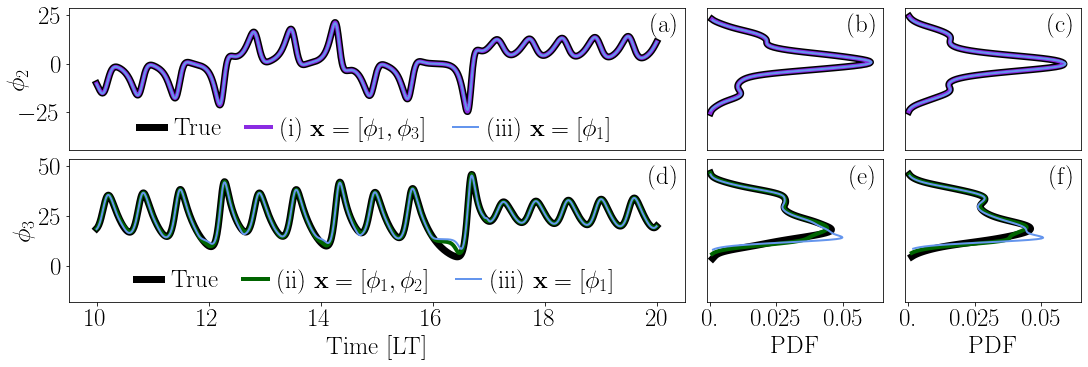

In [7]:
#we plot here the reconstruction in an interval of the training set panels (a)-(d)
# and the PDFs for the reconstruction in the entirety of the training (b)-(e) and test (c)-(f) sets

plt.rcParams["figure.figsize"] = (15,5)
plt.rcParams["font.size"] = 30

axx = plt.figure()

gs = GridSpec(2, 3, width_ratios=[3.5, 1, 1])

ax = axx.add_subplot(gs[3])
ax.set_ylim(-18,53)
ax.set_ylabel('$\phi_3$', fontsize=25)
ax.set_yticks([0,25,50])

truth = wave[1+begin:1+end,idx_2[-1]]
truth1 = u_exact[end+1:end+horizon,idx_2[-1]]

a_100z  = np.matmul(stored_outputs103[begin:end],W_yz_1000)[:,-1]
a_1000z = np.matmul(stored_outputs102[begin:end],W_z_1000)[:,-1] #for histograms in training

i1, i2 = [1000,2000] # time series interval to plot

ax.plot(np.arange(i1,i2)*0.01,truth[i1:i2], 'k', label='$\\textrm{True}$', linewidth=7.)
ax.plot(np.arange(i1,i2)*0.01,a_1000z[i1:i2],
         'darkgreen', label='(ii) $\mathbf{x}=[\phi_1,\phi_2]$', linewidth=4)
ax.plot(np.arange(i1,i2)*0.01,a_100z[i1:i2],
         'cornflowerblue', label='(iii) $\mathbf{x}=[\phi_1]$', linewidth=2)
ax.set_xlabel('Time [LT]', fontsize=25)

ax.tick_params(axis='both', labelsize=25)

ax.annotate('(d)', xy=(1, 1), xytext=(-5, -5), va='top', ha='right',
             xycoords='axes fraction', textcoords='offset points', fontsize=25)
ax.legend(fontsize=25, loc='lower center', bbox_to_anchor=(0.5,-0.1),
           frameon=False, handletextpad=0.4,labelspacing=.2, ncol=3, columnspacing=1.,
         handlelength=1.)


ax = axx.add_subplot(gs[4])
ax.set_ylim(-18,53)
ax.set_xlim(-0.001,0.065)
ax.set_xticks([0,0.025,0.05])
ax.set_xticklabels(['0.', '0.025', '0.05'])
ax.tick_params(axis='both', labelsize=25)
ax.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    left=False,      # ticks along the bottom edge are off
    right=False,         # ticks along the top edge are off
    labelleft=False) # labels along the bottom edge are off

#PDFs for true data, (ii) and (iii) for variable z in training set
ax.set_xlabel('PDF', fontsize=25)
density = stats.gaussian_kde(truth)
n, x, _ = plt.hist(truth, bins=100, color='white',histtype=u'step', density=True, orientation='horizontal')
density_100z = stats.gaussian_kde(a_100z)
n, x_100z, _ = plt.hist(a_100z, bins=100, color='white',histtype=u'step', density=True, orientation='horizontal')  
density_1000z = stats.gaussian_kde(a_1000z)
n, x_1000z, _ = plt.hist(a_1000z, bins=100, color='white',histtype=u'step', density=True, orientation='horizontal')  
ax.plot(density(x), x, 'k', linewidth=7., label='True')
ax.plot(density_1000z(x_1000z), x_1000z, 'darkgreen', linewidth=4., label='$N_r=1000$',)
ax.plot(density_100z(x_100z), x_100z, 'cornflowerblue', linewidth=2, label='$N_r=100$',)
ax.annotate('(e)', xy=(1, 1), xytext=(-5, -5), va='top', ha='right',
             xycoords='axes fraction', textcoords='offset points', fontsize=25)

ax = axx.add_subplot(gs[5])
ax.set_ylim(-18,53)
ax.set_xlim(-0.001,0.065)
ax.set_xticks([0,0.025,0.05])
ax.set_xticklabels(['0.', '0.025', '0.05'])
ax.tick_params(axis='both', labelsize=25)
ax.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    left=False,      # ticks along the bottom edge are off
    right=False,         # ticks along the top edge are off
    labelleft=False) # labels along the bottom edge are off
ax.set_xlabel('PDF', fontsize=25)

#PDFs for true data, (ii) and (iii) for variable z in test set
density = stats.gaussian_kde(truth1)
n, x, _ = plt.hist(truth1, bins=100, color='white',histtype=u'step', density=True, orientation='horizontal')
density_100z = stats.gaussian_kde(Yt_1000yz[:,-1][np.argsort(Yt_1000yz[:,-1])][2:])
n, x_100z, _ = plt.hist(Yt_1000yz[:,-1][np.argsort(Yt_1000yz[:,-1])][2:],
                        bins=100, color='white',histtype=u'step', density=True, orientation='horizontal')  
density_1000z = stats.gaussian_kde(Yt_1000z)
n, x_1000z, _ = plt.hist(Yt_1000z, bins=100, color='white',histtype=u'step', density=True, orientation='horizontal')  
ax.plot(density(x), x, 'k', linewidth=7., label='True')
ax.plot(density_1000z(x_1000z), x_1000z, 'darkgreen', linewidth=4., label='$N_r=1000$',)
ax.plot(density_100z(x_100z), x_100z, 'cornflowerblue', linewidth=2., label='$N_r=100$',)
ax.annotate('(f)', xy=(1, 1), xytext=(-5, -5), va='top', ha='right',
             xycoords='axes fraction', textcoords='offset points', fontsize=25)

ax = axx.add_subplot(gs[0])
ax.tick_params(
        axis='x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        labelbottom=False)

a_100 = np.matmul(stored_outputs103[begin:end],W_yz_1000)[:,-2]
a_1000 = np.matmul(stored_outputs10[begin:end],W_y_1000)[:,-1]

ax.set_ylim(-45,29)
ax.set_ylabel('$\phi_2$', labelpad=-10, fontsize=25)
truth = wave[1+begin:1+end,idx_1[-1]]
truth1 = u_exact[end+1:end+horizon,idx_1[-1]]
ax.plot(np.arange(i1,i2)*0.01,truth[i1:i2], 'k', label='True', linewidth=7.)
ax.plot(np.arange(i1,i2)*0.01,a_1000[i1:i2],
         'blueviolet', label='(i) $\mathbf{x}=[\phi_1,\phi_3]$' , linewidth=4.)
ax.plot(np.arange(i1,i2)*0.01,a_100[i1:i2],
         'cornflowerblue', label='(iii) $\mathbf{x}=[\phi_1]$', linewidth=2.)
ax.legend(fontsize=25, loc='lower center', bbox_to_anchor=(0.5,-0.1),
           frameon=False, handletextpad=0.4,labelspacing=.2, ncol=3, columnspacing=1.,
         handlelength=1.)
ax.tick_params(axis='both', labelsize=25)
ax.annotate('(a)', xy=(1, 1), xytext=(-5, -5), va='top', ha='right',
             xycoords='axes fraction', textcoords='offset points', fontsize=25)


ax = axx.add_subplot(gs[1])
ax.set_xlim(-0.001,0.065)
ax.tick_params(
        axis='x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        labelbottom=False)
ax.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    left=False,      # ticks along the bottom edge are off
    right=False,         # ticks along the top edge are off
    labelleft=False) # labels along the bottom edge are off
ax.set_ylim(-45,29)
ax.tick_params(axis='both', labelsize=25)
density = stats.gaussian_kde(truth)
n, x, _ = plt.hist(truth, bins=100, color='white',histtype=u'step', density=True, orientation='horizontal')
density_100 = stats.gaussian_kde(a_100)
n, x_100, _ = plt.hist(a_100, bins=100, color='white',histtype=u'step', density=True, orientation='horizontal')  
density_1000 = stats.gaussian_kde(a_1000)
n, x_1000, _ = plt.hist(a_1000, bins=100, color='white',histtype=u'step', density=True, orientation='horizontal')  
ax.plot(density(x), x, 'k', linewidth=7., label='True')
ax.plot(density_1000(x_1000), x_1000, 'blueviolet', linewidth=4, label='$N_r=1000$',)
ax.plot(density_100(x_100), x_100, 'cornflowerblue', linewidth=2, label='$N_r=100$',)

ax.annotate('(b)', xy=(1, 1), xytext=(-5, -5), va='top', ha='right',
             xycoords='axes fraction', textcoords='offset points', fontsize=25)

ax = axx.add_subplot(gs[2])
ax.set_ylim(-45,29)
ax.set_xlim(-0.001,0.065)
ax.set_xticks([0,0.025,0.05])
ax.tick_params(axis='both', labelsize=25)
ax.tick_params(
        axis='x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        labelbottom=False)
ax.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    left=False,      # ticks along the bottom edge are off
    right=False,         # ticks along the top edge are off
    labelleft=False) # labels along the bottom edge are off
# plt.ylim(0,0.065)
density = stats.gaussian_kde(truth1)
n, x, _ = plt.hist(truth1, bins=100, color='white',histtype=u'step', density=True, orientation='horizontal')
density_100z = stats.gaussian_kde(Yt_1000yz[:,-2])
n, x_100z, _ = plt.hist(Yt_1000yz[:,-2], bins=100, color='white',histtype=u'step', density=True, orientation='horizontal')  
density_1000z = stats.gaussian_kde(Yt_1000y)
n, x_1000z, _ = plt.hist(Yt_1000y, bins=100, color='white',histtype=u'step', density=True, orientation='horizontal')  
ax.plot(density(x), x, 'k', linewidth=7., label='True')
ax.plot(density_1000z(x_1000z), x_1000z, 'blueviolet', linewidth=4., label='$N_r=1000$',)
ax.plot(density_100z(x_100z), x_100z, 'cornflowerblue', linewidth=2., label='$N_r=100$',)
ax.annotate('(c)', xy=(1, 1), xytext=(-5, -5), va='top', ha='right',
             xycoords='axes fraction', textcoords='offset points', fontsize=25)

axx.tight_layout(pad=0.1, h_pad=0.2, w_pad=0.01)
plt.show()

## Error in training and test set

In [8]:
#losses and true losses for each case in the training set, F indicates forward euWler
# a is the physics loss and b the true loss

Loss_Mse = tf.keras.losses.MeanSquaredError()

# (i)
a_100 = l_y_100[np.nonzero(l_y_100)]
b_100 = tl_y_100[np.nonzero(tl_y_100)]
a_200 = l_y_200[np.nonzero(l_y_200)]
b_200 = tl_y_200[np.nonzero(tl_y_200)]
a_500 = l_y_500[np.nonzero(l_y_500)]
b_500 = tl_y_500[np.nonzero(tl_y_500)]
a_750 = l_y_750[np.nonzero(l_y_750)]
b_750 = tl_y_750[np.nonzero(tl_y_750)]
a_1000 = l_y_1000[np.nonzero(l_y_1000)]
b_1000 = tl_y_1000[np.nonzero(tl_y_1000)]
a_100F = l_y_100F[np.nonzero(l_y_100F)]
b_100F = tl_y_100F[np.nonzero(tl_y_100F)]
a_200F = l_y_200F[np.nonzero(l_y_200F)]
b_200F = tl_y_200F[np.nonzero(tl_y_200F)]
a_500F = l_y_500F[np.nonzero(l_y_500F)]
b_500F = tl_y_500F[np.nonzero(tl_y_500F)]
a_750F = l_y_750F[np.nonzero(l_y_750F)]
b_750F = tl_y_750F[np.nonzero(tl_y_750F)]
a_1000F = l_y_1000F[np.nonzero(l_y_1000F)]
b_1000F = tl_y_1000F[np.nonzero(tl_y_1000F)]


# (ii)
a_100z = l_z_100[np.nonzero(l_z_100)]
b_100z = tl_z_100[np.nonzero(tl_z_100)]
a_200z = l_z_200[np.nonzero(l_z_200)]
b_200z = tl_z_200[np.nonzero(tl_z_200)]
a_500z = l_z_500[np.nonzero(l_z_500)]
b_500z = tl_z_500[np.nonzero(tl_z_500)]
a_750z = l_z_750[np.nonzero(l_z_750)]
b_750z = tl_z_750[np.nonzero(tl_z_750)]
a_1000z = l_z_1000[np.nonzero(l_z_1000)]
b_1000z = tl_z_1000[np.nonzero(tl_z_1000)]
a_100zF = l_z_100F[np.nonzero(l_z_100F)]
b_100zF = tl_z_100F[np.nonzero(tl_z_100F)]
a_200zF = l_z_200F[np.nonzero(l_z_200F)]
b_200zF = tl_z_200F[np.nonzero(tl_z_200F)]
a_500zF = l_z_500F[np.nonzero(l_z_500F)]
b_500zF = tl_z_500F[np.nonzero(tl_z_500F)]
a_750zF = l_z_750F[np.nonzero(l_z_750F)]
b_750zF = tl_z_750F[np.nonzero(tl_z_750F)]
a_1000zF = l_z_1000F[np.nonzero(l_z_1000F)]
b_1000zF = tl_z_1000F[np.nonzero(tl_z_1000F)]

# (iii)
yz_100 = np.matmul(stored_outputs13[begin:end],W_yz_100)
yz_200 = np.matmul(stored_outputs23[begin:end],W_yz_200)
yz_500 = np.matmul(stored_outputs53[begin:end],W_yz_500)
yz_750 = np.matmul(stored_outputs73[begin:end],W_yz_750)
yz_1000 = np.matmul(stored_outputs103[begin:end],W_yz_1000)
yz_100F = np.matmul(stored_outputs13[begin:end],W_yz_100F)
yz_200F = np.matmul(stored_outputs23[begin:end],W_yz_200F)
yz_500F = np.matmul(stored_outputs53[begin:end],W_yz_500F)
yz_750F = np.matmul(stored_outputs73[begin:end],W_yz_750F)
yz_1000F = np.matmul(stored_outputs103[begin:end],W_yz_1000F)

b_100_y = Loss_Mse(yz_100[:,0],u_exact[begin+1:end+1,1]).numpy()
b_200_y = Loss_Mse(yz_200[:,0],u_exact[begin+1:end+1,1]).numpy()
b_500_y = Loss_Mse(yz_500[:,0],u_exact[begin+1:end+1,1]).numpy()
b_750_y = Loss_Mse(yz_750[:,0],u_exact[begin+1:end+1,1]).numpy()
b_1000_y = Loss_Mse(yz_1000[:,0],u_exact[begin+1:end+1,1]).numpy()
b_100_yF = Loss_Mse(yz_100F[:,0],u_exact[begin+1:end+1,1]).numpy()
b_200_yF = Loss_Mse(yz_200F[:,0],u_exact[begin+1:end+1,1]).numpy()
b_500_yF = Loss_Mse(yz_500F[:,0],u_exact[begin+1:end+1,1]).numpy()
b_750_yF = Loss_Mse(yz_750F[:,0],u_exact[begin+1:end+1,1]).numpy()
b_1000_yF = Loss_Mse(yz_1000F[:,0],u_exact[begin+1:end+1,1]).numpy()

b_100_z = Loss_Mse(yz_100[:,1],u_exact[begin+1:end+1,2]).numpy()
b_200_z = Loss_Mse(yz_200[:,1],u_exact[begin+1:end+1,2]).numpy()
b_500_z = Loss_Mse(yz_500[:,1],u_exact[begin+1:end+1,2]).numpy()
b_750_z = Loss_Mse(yz_750[:,1],u_exact[begin+1:end+1,2]).numpy()
b_1000_z = Loss_Mse(yz_1000[:,1],u_exact[begin+1:end+1,2]).numpy()
b_100_zF = Loss_Mse(yz_100F[:,1],u_exact[begin+1:end+1,2]).numpy()
b_200_zF = Loss_Mse(yz_200F[:,1],u_exact[begin+1:end+1,2]).numpy()
b_500_zF = Loss_Mse(yz_500F[:,1],u_exact[begin+1:end+1,2]).numpy()
b_750_zF = Loss_Mse(yz_750F[:,1],u_exact[begin+1:end+1,2]).numpy()
b_1000_zF = Loss_Mse(yz_1000F[:,1],u_exact[begin+1:end+1,2]).numpy()

In [9]:
# open-loop in the test set (that lasts 100 Lyapunov Times after the training set)
# to compute the error in the test set for the different sizes of the reservoir and AD vs FE

#(i)
new_input1 = u_exact[end+1:end+horizon,idx1]
new_input1 = new_input1.reshape(1,new_input1.shape[0],new_input1.shape[1])
out_100   = outputs(new_input1,final_state1, ESN1)[0][0,:,:]
out_200   = outputs(new_input1,final_state2, ESN2)[0][0,:,:]  
out_500   = outputs(new_input1,final_state5, ESN5)[0][0,:,:]  
out_750   = outputs(new_input1,final_state7, ESN7)[0][0,:,:]  
out_1000  = outputs(new_input1,final_state10, ESN10)[0][0,:,:]  
Ytest_100 = np.matmul(out_100, W_y_100)
Ytest_200 = np.matmul(out_200, W_y_200)
Ytest_500 = np.matmul(out_500, W_y_500)
Ytest_750 = np.matmul(out_750, W_y_750)
Ytest_1000 = np.matmul(out_1000, W_y_1000)
Ytest_100F = np.matmul(out_100, W_y_100F)
Ytest_200F = np.matmul(out_200, W_y_200F)
Ytest_500F = np.matmul(out_500, W_y_500F)
Ytest_750F = np.matmul(out_750, W_y_750F)
Ytest_1000F = np.matmul(out_1000, W_y_1000F)

#(ii)
new_input2 = u_exact[end+1:end+horizon,idx2]
new_input2 = new_input2.reshape(1,new_input2.shape[0],new_input2.shape[1])
out_100   = outputs(new_input2,final_state12, ESN1)[0][0,:,:]
out_200   = outputs(new_input2,final_state22, ESN2)[0][0,:,:]  
out_500   = outputs(new_input2,final_state52, ESN5)[0][0,:,:]  
out_750   = outputs(new_input2,final_state72, ESN7)[0][0,:,:]  
out_1000  = outputs(new_input2,final_state102, ESN10)[0][0,:,:]  
Ytest_100z = np.matmul(out_100, W_z_100)
Ytest_200z = np.matmul(out_200, W_z_200)
Ytest_500z = np.matmul(out_500, W_z_500)
Ytest_750z = np.matmul(out_750, W_z_750)
Ytest_1000z = np.matmul(out_1000, W_z_1000)
Ytest_100zF = np.matmul(out_100, W_z_100F)
Ytest_200zF = np.matmul(out_200, W_z_200F)
Ytest_500zF = np.matmul(out_500, W_z_500F)
Ytest_750zF = np.matmul(out_750, W_z_750F)
Ytest_1000zF = np.matmul(out_1000, W_z_1000F)

#(iii)
new_input3 = u_exact[end+1:end+horizon,idx3]
new_input3 = new_input3.reshape(1,new_input3.shape[0],new_input3.shape[1])
out_100   = outputs(new_input3,final_state13, ESN13)[0][0,:,:]
out_200   = outputs(new_input3,final_state23, ESN23)[0][0,:,:]  
out_500   = outputs(new_input3,final_state53, ESN53)[0][0,:,:]  
out_750   = outputs(new_input3,final_state73, ESN73)[0][0,:,:]  
out_1000  = outputs(new_input3,final_state103, ESN103)[0][0,:,:]  
Ytest_100yz = np.matmul(out_100, W_yz_100)
Ytest_200yz = np.matmul(out_200, W_yz_200)
Ytest_500yz = np.matmul(out_500, W_yz_500)
Ytest_750yz = np.matmul(out_750, W_yz_750)
Ytest_1000yz = np.matmul(out_1000, W_yz_1000)
Ytest_100yzF = np.matmul(out_100, W_yz_100F)
Ytest_200yzF = np.matmul(out_200, W_yz_200F)
Ytest_500yzF = np.matmul(out_500, W_yz_500F)
Ytest_750yzF = np.matmul(out_750, W_yz_750F)
Ytest_1000yzF = np.matmul(out_1000, W_yz_1000F)

### NRMSE Plots

/home/ar994/.local/lib/python3.6/site-packages/ipykernel_launcher.py:157: UserWarning: FixedFormatter should only be used together with FixedLocator


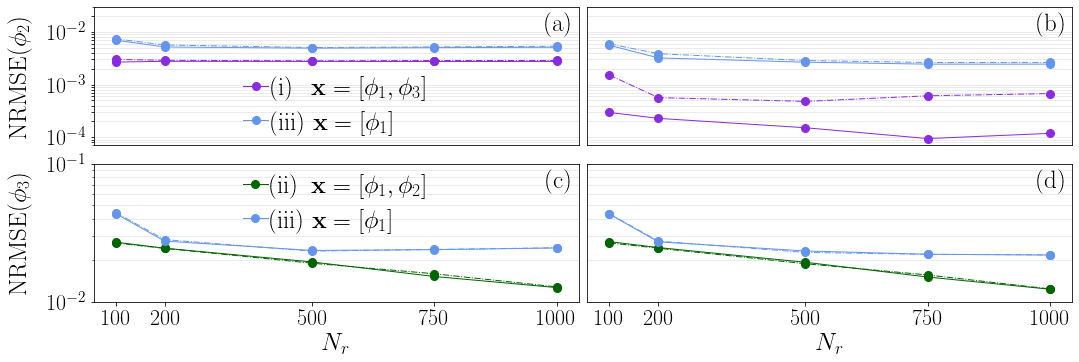

In [10]:
#Normalized MSE in test set automatic differentiation (square root to get NRMSE later)
b_1  = np.array([Loss_Mse(u_exact[end+2:end+horizon+1,idx_1[-1]], Ytest_100[:,-1]).numpy()/norm[idx_1[-1]]**2,
                 Loss_Mse(u_exact[end+2:end+horizon+1,idx_1[-1]], Ytest_200[:,-1]).numpy()/norm[idx_1[-1]]**2,
                 Loss_Mse(u_exact[end+2:end+horizon+1,idx_1[-1]], Ytest_500[:,-1]).numpy()/norm[idx_1[-1]]**2,
                 Loss_Mse(u_exact[end+2:end+horizon+1,idx_1[-1]], Ytest_750[:,-1]).numpy()/norm[idx_1[-1]]**2,
                 Loss_Mse(u_exact[end+2:end+horizon+1,idx_1[-1]], Ytest_1000[:,-1]).numpy()/norm[idx_1[-1]]**2,
                 Loss_Mse(u_exact[end+2:end+horizon+1,idx_1[-1]], Ytest_100yz[:,-2]).numpy()/norm[idx_1[-1]]**2,
                 Loss_Mse(u_exact[end+2:end+horizon+1,idx_1[-1]], Ytest_200yz[:,-2]).numpy()/norm[idx_1[-1]]**2,
                 Loss_Mse(u_exact[end+2:end+horizon+1,idx_1[-1]], Ytest_500yz[:,-2]).numpy()/norm[idx_1[-1]]**2,
                 Loss_Mse(u_exact[end+2:end+horizon+1,idx_1[-1]], Ytest_750yz[:,-2]).numpy()/norm[idx_1[-1]]**2,
                 Loss_Mse(u_exact[end+2:end+horizon+1,idx_1[-1]], Ytest_1000yz[:,-2]).numpy()/norm[idx_1[-1]]**2,
                 #
                 Loss_Mse(u_exact[end+2:end+horizon+1,idx_2[-1]], Ytest_100z[:,-1]).numpy()/norm[idx_2[-1]]**2,
                 Loss_Mse(u_exact[end+2:end+horizon+1,idx_2[-1]], Ytest_200z[:,-1]).numpy()/norm[idx_2[-1]]**2,
                 Loss_Mse(u_exact[end+2:end+horizon+1,idx_2[-1]], Ytest_500z[:,-1]).numpy()/norm[idx_2[-1]]**2,
                 Loss_Mse(u_exact[end+2:end+horizon+1,idx_2[-1]], Ytest_750z[:,-1]).numpy()/norm[idx_2[-1]]**2,
                 Loss_Mse(u_exact[end+2:end+horizon+1,idx_2[-1]], Ytest_1000z[:,-1]).numpy()/norm[idx_2[-1]]**2,
                 Loss_Mse(u_exact[end+2:end+horizon+1,idx_2[-1]], Ytest_100yz[:,-1]).numpy()/norm[idx_2[-1]]**2,
                 Loss_Mse(u_exact[end+2:end+horizon+1,idx_2[-1]], Ytest_200yz[:,-1]).numpy()/norm[idx_2[-1]]**2,
                 Loss_Mse(u_exact[end+2:end+horizon+1,idx_2[-1]], Ytest_500yz[:,-1]).numpy()/norm[idx_2[-1]]**2,
                 Loss_Mse(u_exact[end+2:end+horizon+1,idx_2[-1]], Ytest_750yz[:,-1]).numpy()/norm[idx_2[-1]]**2,
                 Loss_Mse(u_exact[end+2:end+horizon+1,idx_2[-1]], Ytest_1000yz[:,-1]).numpy()/norm[idx_2[-1]]**2])

#Normalized MSE in test set forward euler
b_1F = np.array([Loss_Mse(u_exact[end+2:end+horizon+1,idx_1[-1]], Ytest_100F[:,-1]).numpy()/norm[idx_1[-1]]**2,
                 Loss_Mse(u_exact[end+2:end+horizon+1,idx_1[-1]], Ytest_200F[:,-1]).numpy()/norm[idx_1[-1]]**2,
                 Loss_Mse(u_exact[end+2:end+horizon+1,idx_1[-1]], Ytest_500F[:,-1]).numpy()/norm[idx_1[-1]]**2,
                 Loss_Mse(u_exact[end+2:end+horizon+1,idx_1[-1]], Ytest_750F[:,-1]).numpy()/norm[idx_1[-1]]**2,
                 Loss_Mse(u_exact[end+2:end+horizon+1,idx_1[-1]], Ytest_1000F[:,-1]).numpy()/norm[idx_1[-1]]**2,
                 Loss_Mse(u_exact[end+2:end+horizon+1,idx_1[-1]], Ytest_100yzF[:,-2]).numpy()/norm[idx_1[-1]]**2,
                 Loss_Mse(u_exact[end+2:end+horizon+1,idx_1[-1]], Ytest_200yzF[:,-2]).numpy()/norm[idx_1[-1]]**2,
                 Loss_Mse(u_exact[end+2:end+horizon+1,idx_1[-1]], Ytest_500yzF[:,-2]).numpy()/norm[idx_1[-1]]**2,
                 Loss_Mse(u_exact[end+2:end+horizon+1,idx_1[-1]], Ytest_750yzF[:,-2]).numpy()/norm[idx_1[-1]]**2,
                 Loss_Mse(u_exact[end+2:end+horizon+1,idx_1[-1]], Ytest_1000yzF[:,-2]).numpy()/norm[idx_1[-1]]**2,
                 #
                 Loss_Mse(u_exact[end+2:end+horizon+1,idx_2[-1]], Ytest_100zF[:,-1]).numpy()/norm[idx_2[-1]]**2,
                 Loss_Mse(u_exact[end+2:end+horizon+1,idx_2[-1]], Ytest_200zF[:,-1]).numpy()/norm[idx_2[-1]]**2,
                 Loss_Mse(u_exact[end+2:end+horizon+1,idx_2[-1]], Ytest_500zF[:,-1]).numpy()/norm[idx_2[-1]]**2,
                 Loss_Mse(u_exact[end+2:end+horizon+1,idx_2[-1]], Ytest_750zF[:,-1]).numpy()/norm[idx_2[-1]]**2,
                 Loss_Mse(u_exact[end+2:end+horizon+1,idx_2[-1]], Ytest_1000zF[:,-1]).numpy()/norm[idx_2[-1]]**2,
                 Loss_Mse(u_exact[end+2:end+horizon+1,idx_2[-1]], Ytest_100yzF[:,-1]).numpy()/norm[idx_2[-1]]**2,
                 Loss_Mse(u_exact[end+2:end+horizon+1,idx_2[-1]], Ytest_200yzF[:,-1]).numpy()/norm[idx_2[-1]]**2,
                 Loss_Mse(u_exact[end+2:end+horizon+1,idx_2[-1]], Ytest_500yzF[:,-1]).numpy()/norm[idx_2[-1]]**2,
                 Loss_Mse(u_exact[end+2:end+horizon+1,idx_2[-1]], Ytest_750yzF[:,-1]).numpy()/norm[idx_2[-1]]**2,
                 Loss_Mse(u_exact[end+2:end+horizon+1,idx_2[-1]], Ytest_1000yzF[:,-1]).numpy()/norm[idx_2[-1]]**2])

#Normalized MSE in training set automatic differentiation
b_2  = np.array([b_100z[-1]/norm[idx_2[-1]]**2,b_200z[-1]/norm[idx_2[-1]]**2,
                 b_500z[-1]/norm[idx_2[-1]]**2,b_750z[-1]/norm[idx_2[-1]]**2,
                 b_1000z[-1]/norm[idx_2[-1]]**2,b_100_z/norm[idx_2[-1]]**2,
                 b_200_z/norm[idx_2[-1]]**2,b_500_z/norm[idx_2[-1]]**2,
                 b_750_z/norm[idx_2[-1]]**2,b_1000_z/norm[idx_2[-1]]**2,
                 #
                 b_100[-1]/norm[idx_1[-1]]**2,b_200[-1]/norm[idx_1[-1]]**2,
                 b_500[-1]/norm[idx_1[-1]]**2,b_750[-1]/norm[idx_1[-1]]**2,
                 b_1000[-1]/norm[idx_1[-1]]**2,b_100_y/norm[idx_1[-1]]**2,
                 b_200_y/norm[idx_1[-1]]**2.,b_500_y/norm[idx_1[-1]]**2,
                 b_750_y/norm[idx_1[-1]]**2,b_1000_y/norm[idx_1[-1]]**2])

#Normalized MSE in training set forward euler
b_2F = np.array([b_100zF[-1]/norm[idx_2[-1]]**2,b_200zF[-1]/norm[idx_2[-1]]**2,
                 b_500zF[-1]/norm[idx_2[-1]]**2,b_750zF[-1]/norm[idx_2[-1]]**2,
                 b_1000zF[-1]/norm[idx_2[-1]]**2,b_100_zF/norm[idx_2[-1]]**2,
                 b_200_zF/norm[idx_2[-1]]**2,b_500_zF/norm[idx_2[-1]]**2,
                 b_750_zF/norm[idx_2[-1]]**2,b_1000_zF/norm[idx_2[-1]]**2,
                 #
                 b_100F[-1]/norm[idx_1[-1]]**2,b_200F[-1]/norm[idx_1[-1]]**2,
                 b_500F[-1]/norm[idx_1[-1]]**2,b_750F[-1]/norm[idx_1[-1]]**2,
                 b_1000F[-1]/norm[idx_1[-1]]**2,b_100_yF/norm[idx_1[-1]]**2,
                 b_200_yF/norm[idx_1[-1]]**2.,b_500_yF/norm[idx_1[-1]]**2,
                 b_750_yF/norm[idx_1[-1]]**2,b_1000_yF/norm[idx_1[-1]]**2])


#panel (a)-(c) are results for FE and (b)-(d) for AD
#dash-dotted lines are test set resutls and continuous lines training set

##
plt.rcParams["figure.figsize"] = (15,5)
plt.rcParams["font.size"] = 30
ax1, fig = plt.subplots(2,2)

x_array = np.array([1,2,5,7.5,10])

axx = plt.subplot(2,2,3)
plt.ylim(0.0099,0.1)
plt.grid(True, which="both", axis='y', ls="-", alpha=0.3)
# plt.xscale('log')
plt.ylabel('NRMSE$(\phi_3)$',labelpad=15, fontsize=25)
plt.plot(x_array,np.sqrt(b_1F[10:15]), c='darkgreen', marker='o', linestyle='-.', linewidth=1,
         markersize=8)
plt.plot(x_array,np.sqrt(b_1F[15:20]), c='cornflowerblue', marker='o', linestyle='-.', linewidth=1,
         markersize=8)
plt.plot(x_array,np.sqrt(b_2F[:5]), c='darkgreen', marker='o', linewidth=1, markersize=8,
         label='(ii) $\:\mathbf{x}=[\phi_1,\phi_2]$')
plt.plot(x_array,np.sqrt(b_2F[5:10]), c='cornflowerblue', marker='o', linewidth=1, markersize=8,
        label='(iii) $\mathbf{x}=[\phi_1]$')


axx.set_yscale('log')
plt.tick_params(axis='y', labelsize=22)
plt.legend(fontsize=25, loc='upper center', bbox_to_anchor=(.5,1.09),
           frameon=False, handletextpad=0.1,labelspacing=.4, handlelength=1)
plt.annotate('(c)', xy=(1, 1), xytext=(-5, -5), va='top', ha='right',
             xycoords='axes fraction', textcoords='offset points', fontsize=25)
plt.xticks(x_array,['$100$', '$200$', '$500$', '$750$', '$1000$'],fontsize=22)
plt.xlabel('$N_r$',  fontsize=25)


axx = plt.subplot(2,2,1)
plt.grid(True, which="both", axis='y', ls="-", alpha=0.3)
plt.yscale('log')
plt.yticks([1e-4,9e-4,8e-4,7e-4,6e-4,5e-4,4e-4,3e-4,2e-4,9e-5,8e-5,
            1e-3,9e-3,8e-3,7e-3,6e-3,5e-3,4e-3,3e-3,2e-3,
            1e-2,2e-2])
# plt.xscale('log')
plt.plot(x_array,np.sqrt(b_1F[0:5]), c='blueviolet', marker='o', linestyle='-.', linewidth=1
         , markersize=8)
plt.plot(x_array,np.sqrt(b_1F[5:10]), c='cornflowerblue', marker='o', linestyle='-.', linewidth=1
         , markersize=8)
plt.plot(x_array,np.sqrt(b_2F[10:15]), c='blueviolet', marker='o', linewidth=1, markersize=8,
         label='(i) $\;\,\mathbf{x}=[\phi_1,\phi_3]$')
plt.plot(x_array,np.sqrt(b_2F[15:20]), c='cornflowerblue', marker='o', linewidth=1, markersize=8,
        label='(iii) $\mathbf{x}=[\phi_1]$')
plt.ylim(7e-5, 3e-2)
# plt.tick_params(axis='x', pad=7)
plt.tick_params(axis='y', labelsize=22)
plt.ylabel('NRMSE$(\phi_2)$', labelpad=15, fontsize=25)
plt.tick_params(
        axis='x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        labelbottom=False)
# axx.yaxis.tick_right()
# axx.yaxis.set_label_position("right")
plt.annotate('(a)', xy=(1, 1), xytext=(-5, -5), va='top', ha='right',
             xycoords='axes fraction', textcoords='offset points', fontsize=25)
plt.legend(fontsize=25, loc='lower center', bbox_to_anchor=(.5,-.09),
           frameon=False, handletextpad=0.1,labelspacing=.4, handlelength=1)


axx = plt.subplot(2,2,4)
plt.ylim(0.0099,0.1)
plt.grid(True, which="both", axis='y', ls="-", alpha=0.3)
plt.plot(x_array,np.sqrt(b_1[10:15]), c='darkgreen', marker='o', linestyle='-.', linewidth=1,
         markersize=8)
plt.plot(x_array,np.sqrt(b_1[15:20]), c='cornflowerblue', marker='o', linestyle='-.', linewidth=1,
         markersize=8)
plt.plot(x_array,np.sqrt(b_2[:5]), c='darkgreen', marker='o', linewidth=1, markersize=8,
         label='$\mathbf{x}=[\phi_1,\phi_2]$')
plt.plot(x_array,np.sqrt(b_2[5:10]), c='cornflowerblue', marker='o', linewidth=1, markersize=8,
        label='$\mathbf{x}=[\phi_1]$')


labels = [item.get_text() for item in axx.get_yticklabels()]
empty_string_labels = ['']*len(labels)
axx.set_yticklabels(empty_string_labels)
axx.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    left=False,      # ticks along the bottom edge are off
    right=False,         # ticks along the top edge are off
    labelleft=False) 
plt.tick_params(axis='y', labelsize=22)

axx.set_yscale('log')
# plt.legend(fontsize=25, loc='upper center', bbox_to_anchor=(.5,1.08),
#            frameon=False, handletextpad=0.1,labelspacing=.2)
plt.annotate('(d)', xy=(1, 1), xytext=(-5, -5), va='top', ha='right',
             xycoords='axes fraction', textcoords='offset points', fontsize=25)
plt.xticks(x_array,['$100$', '$200$', '$500$', '$750$', '$1000$'],fontsize=22)
plt.xlabel('$N_r$',  fontsize=25)


axx = plt.subplot(2,2,2)
plt.grid(True, which="both", axis='y', ls="-", alpha=0.3)
plt.yscale('log')
plt.plot(x_array,np.sqrt(b_1[0:5]), c='blueviolet', marker='o', linestyle='-.', linewidth=1
         , markersize=8)
plt.plot(x_array,np.sqrt(b_1[5:10]), c='cornflowerblue', marker='o', linestyle='-.', linewidth=1
         , markersize=8)
plt.plot(x_array,np.sqrt(b_2[10:15]), c='blueviolet', marker='o', linewidth=1, markersize=8,
         label='$\mathbf{x}=[\phi_1,\phi_3]$')
plt.plot(x_array,np.sqrt(b_2[15:20]), c='cornflowerblue', marker='o', linewidth=1, markersize=8,
        label='$\mathbf{x}=[\phi_1]$')
plt.ylim(7e-5, 3e-2)
plt.yticks([1e-4,9e-4,8e-4,7e-4,6e-4,5e-4,4e-4,3e-4,2e-4,9e-5,8e-5,
            1e-3,9e-3,8e-3,7e-3,6e-3,5e-3,4e-3,3e-3,2e-3,
            1e-2,2e-2])

labels = [item.get_text() for item in axx.get_yticklabels()]
empty_string_labels = ['']*len(labels)
axx.set_yticklabels(empty_string_labels)

plt.tick_params(
        axis='x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        labelbottom=False)
axx.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    left=False,      # ticks along the bottom edge are off
    right=False,         # ticks along the top edge are off
    labelleft=False) 
plt.tick_params(axis='y', labelsize=22)

plt.annotate('(b)', xy=(1, 1), xytext=(-5, -5), va='top', ha='right',
             xycoords='axes fraction', textcoords='offset points', fontsize=25)
# plt.legend(fontsize=25, loc='upper center', bbox_to_anchor=(.5,1.09),
#            frameon=False, handletextpad=0.1,labelspacing=.2)

ax1.tight_layout(pad=0.2)
plt.show()

## Accuracy of automatic differentiation and forward euler

In a case where the entire state is known (no reconstruction) we compare the accuracy of automatic differentiation and forward euler

MSE in training set: 3.8111645039862196e-07 0.0016332531813532114 23.321693420410156


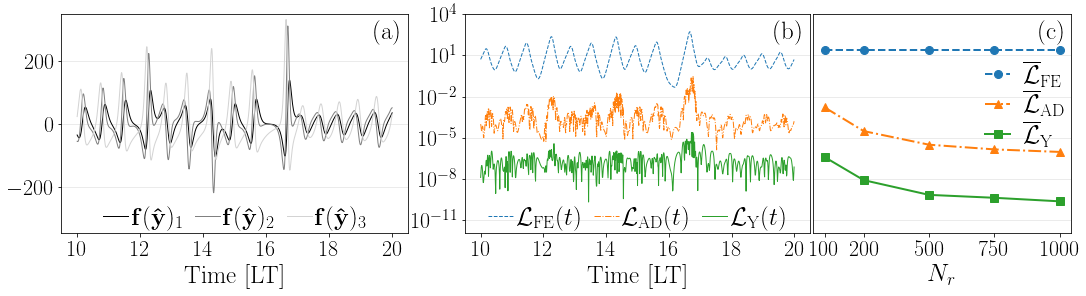

In [11]:
num_units = num_units1
sparseness = 1. - connectivity/ (num_units1 - 1.) # sparseness 
idx = [0,1,2]

# Initialize the ESN cell
rng        = np.random.RandomState(random_seed)
cell_new = EchoStateRNNCell(num_units=num_units, 
                        num_inputs=Nx,
                        activation=activation, 
                        decay=decay, # decay (leakage) rate
                        rho=rho_spectral, # spectral radius of echo matrix
                        sigma_in=sigma_in, # scaling of input matrix
                        b_in = b_in,
                        sparseness = sparseness, # sparsity of the echo matrix
                        rng=rng)
ESN_new   = tf.keras.layers.RNN(cell=cell_new,dtype=tf.float64,
                                              return_sequences=True, return_state=True)

#run the network in the training set to obtain the output matrix
rnn_init_state = tf.constant(np.zeros([batches, num_units]))
rnn_inputs     = wave[:-1,idx].reshape(1,end, Nx)
rnn_target     = wave[1:,idx]
stored_outputs = outputs(rnn_inputs, rnn_init_state, ESN_new)[0][0].numpy()
XX_train = stored_outputs[begin:end,:] 
# since the entire state is known the entire output matrix is computed via ridge rigression
LHS   = np.dot(XX_train.T, XX_train) + lmb*np.eye(num_units+Nx+1)
RHS   = np.dot(XX_train.T, rnn_target[begin:end,:])
Wout  = np.linalg.solve(LHS, RHS)

# These files can be obtained by running API-ESN_Trainig.ipynb using idx=[0,1,2] up to
# 'Compute the output matrix for the hidden state'
hf   = h5py.File('./data/Lorenz_Rec_drdt_'+ str(idx) +'_' + str(num_units) + '_' + str(end) + '.h5','r')
dr   = np.array(hf.get('drdt'))
r    = np.array(hf.get('r'))
hf.close()

#Compute the output and derivative
y_pred = np.matmul(r[0,begin:end], Wout)  #output
fy     = Lorenz_RHS(y_pred)               #true derivative at the output
y_dot  = np.matmul(dr[0,begin:end], Wout) #derivative using automatic differentiation
y_eul  = (y_pred[1:] - y_pred[:-1])/dt    #derivative using forward euler

# MSE in training set
RR_0  = Loss_Mse(y_pred[:-1],rnn_target[begin:end-1,:]).numpy() #output
API_0 = Loss_Mse(y_dot[:-1] ,fy[:-1]).numpy() #derivative output with ad
PI_0  = Loss_Mse(y_eul      ,fy[:-1]).numpy() #derivative output wi fe
print('MSE in training set:', RR_0, API_0, PI_0)

#MSE in the training set for the output prediction for different sizes of the reservori 
RR  = np.array([3.81e-7,7.83e-9, 6.58e-10, 4.03e-10, 2.22e-10])
#error in the output derivative using automatic differentiation (API) and forward euler (PI)
API = np.array([1.63e-3, 2.99e-5, 3.04e-6, 1.38e-6, 9.01e-7])
PI  = np.array([23.32, 23.32, 23.32, 23.32, 23.32])
# These 3 are obtained by running RR_0,API_0,PI_0 for all cases


#Plot
plt.rcParams["figure.figsize"] = (15,4)
plt.rcParams["font.size"] = 30
from matplotlib.gridspec import *

Nr  = np.array([100, 250, 500, 750, 1000]) #neurons
i1, i2 = [1000,2000]  #range to plot

x   = np.arange(i1,i2)*0.01
x1  = np.arange(i1,i2-1)*0.01

axx = plt.figure()


gs = GridSpec(1, 2, width_ratios=[1., 1.75], figure=axx, wspace=0.01)

gs00 = GridSpecFromSubplotSpec(1, 2, width_ratios=[2., 1.5], subplot_spec=gs[1], wspace=0.01)

ax = axx.add_subplot(gs[0])

ax.tick_params(axis='both', labelsize=22)
ax.set_xlabel('Time [LT]', fontsize=25)
ax.set_ylim(-350,350)
ax.set_xticks([10.,12,14.,16.,18,20])

ax.plot(x,fy[i1:i2,0], 'k', linewidth=1, label='$\mathbf{f}(\mathbf{\hat{y}})_1$')
ax.plot(x,fy[i1:i2,1], 'grey', linewidth=1, label='$\mathbf{f}(\mathbf{\hat{y}})_2$')
ax.plot(x,fy[i1:i2,2], 'lightgray', linewidth=1, label='$\mathbf{f}(\mathbf{\hat{y}})_3$')

ax.grid(True, which="both", axis='y', ls="-", alpha=0.3)
ax.annotate('(a)', xy=(1, 1), xytext=(-5, -5), va='top', ha='right',
             xycoords='axes fraction', textcoords='offset points', fontsize=25)
ax.legend(fontsize=25, loc='lower center', bbox_to_anchor=(0.5,-.09),
            frameon=False, handletextpad=0.1,labelspacing=.2,columnspacing=.5, ncol=3,
          handlelength=1.)

ax = axx.add_subplot(gs00[0])

ax.tick_params(axis='both', labelsize=22)
ax.set_xlabel('Time [LT]', fontsize=25)
ax.set_yscale('log')
ax.set_ylim(1e-12,1e3)
ax.set_yticks([1e-11,1e-8,1e-5,1e-2,1e1,1e4])
ax.set_xticks([10.,12,14.,16.,18,20])
ax.grid(True, which="both", axis='y', ls="-", alpha=0.3)
ax.plot(x, np.linalg.norm(y_eul[i1-1:i2-1,:] - fy[i1:i2,:],axis=1)**2/3, c='C0', linestyle='--',
        linewidth=1,
        label='$\mathcal{L}_{\mathrm{FE}}(t)$')
ax.plot(x, np.linalg.norm(y_dot[i1:i2,:] - fy[i1:i2,:],axis=1)**2/3, c='C1', linestyle='-.',
        linewidth=1,
        label='$\mathcal{L}_{\mathrm{AD}}(t)$')
ax.plot(x, np.linalg.norm(y_pred[i1:i2,:] - rnn_inputs[0,begin+i1+1:begin+i2+1],axis=1)**2/3, c='C2',
       linewidth=1,
        label='$\mathcal{L}_{\mathrm{Y}}(t)$')
ax.annotate('(b)', xy=(1, 1), xytext=(-5, -5), va='top', ha='right',
             xycoords='axes fraction', textcoords='offset points', fontsize=25)
ax.legend(fontsize=25, loc='lower center', bbox_to_anchor=(0.5,-.09),
            frameon=False, handletextpad=0.1,labelspacing=.2,columnspacing=.5, ncol=3,
          handlelength=1.)

ax = axx.add_subplot(gs00[1])
ax.set_ylim(1e-12,1e3)
ax.set_yscale('log')
ax.plot(Nr, PI,  label='$\overline{\mathcal{L}}_{\mathrm{FE}}$', linestyle='--',
        linewidth=2,marker='o',markersize=8)
ax.plot(Nr, API, label='$\overline{\mathcal{L}}_{\mathrm{AD}}$', linestyle='-.',
        linewidth=2,marker='^',markersize=8)
ax.plot(Nr, RR,  label='$\overline{\mathcal{L}}_{\mathrm{Y}}$', linewidth=2, c='C2',
        marker='s',markersize=8)
ax.tick_params(axis='both', labelsize=22)
ax.set_xticks(Nr)
ax.set_xlabel('$N_r$', fontsize=25)
ax.set_yticks([1e-11,1e-8,1e-5,1e-2,1e1,1e4])
ax.set_xticklabels(['$100$', '$200$', '$500$', '$750$', '$1000$'],fontsize=22)
ax.legend(fontsize=25, loc='upper right', bbox_to_anchor=(1.06,.88),
            frameon=False, handletextpad=0.5,labelspacing=.2, handlelength=1.)
ax.grid(True, which="both", axis='y', ls="-", alpha=0.3)
ax.annotate('(c)', xy=(1, 1), xytext=(-5, -5), va='top', ha='right',
             xycoords='axes fraction', textcoords='offset points', fontsize=25)
ax.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    left=False,      # ticks along the bottom edge are off
    right=False,         # ticks along the top edge are off
    labelleft=False) 

gs.tight_layout(axx,pad=0.1)
plt.show()
